This notebook implements a very simple sequential network with pytorch. The dataset used is very small, and only used for some preliminary trials. The dataset is composed of three T1 images (class 0) and three FA images (class 1). The aim of this simple network is to classify images into the two classes. The training is done using a GPU.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms

torch.set_printoptions(edgeitems=2)
torch.manual_seed(0)

In [2]:
#mount the drive folder
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/work/my_tests

Mounted at /content/drive
/content/drive/My Drive/work/my_tests


In [3]:
#load the dataset as an instance of the class customDataset
import os
from customDataset import HCPanatDataset

img_dir = 'HCP-anat-data/images/'
dataset = HCPanatDataset(csv_file='HCP-anat-data/annotations.csv', root_dir=img_dir)

Training on device cuda.


In [4]:
#transform in torch tensor with transforms.ToTensor()
dataset_t = HCPanatDataset(csv_file='HCP-anat-data/annotations.csv', root_dir=img_dir, transform=transforms.ToTensor())

In [5]:
#compute the mean and std of the data
t1, _ = dataset[0]
max_dim = len(t1.shape) #concatenating dimension
imgs = torch.stack([img_t for img_t, _ in dataset_t], dim=max_dim)
mean = torch.mean(imgs)
std = torch.std(imgs)

In [6]:
#normalize the data
transformed_dataset = HCPanatDataset(
    csv_file='HCP-anat-data/annotations.csv', 
    root_dir=img_dir, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std)]))

In [7]:
#split the dataset into training and test sets with torch.utils.data.random_split
from torch.utils.data import random_split
N = len(transformed_dataset)
perc_train = 0.8
train_set, test_set = random_split(transformed_dataset, [int(perc_train*N), N-int(perc_train*N)]) 
print("Total number of images: %i" %N)
print("Number of training images: %i" %(perc_train*N))
print("Number of test images: %i" %(N-int(perc_train*N)))

Total number of images: 6
Number of training images: 4
Number of test images: 2


In [8]:
#assuming that we are on a CUDA machine, this should print a CUDA device:
device = (torch.device('cuda') if torch.cuda.is_available() 
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [9]:
#define the sequence of models with nn.Sequential()
import torch.nn as nn
n_in = imgs.shape[0] * imgs.shape[1] * imgs.shape[2] #number of input features
n_out = 2 #number of output features, i.e. number of classes
seq_model = nn.Sequential(
            nn.Linear(n_in, 128), 
            nn.Tanh(),
            nn.Linear(128, n_out))
seq_model = seq_model.to(device=device)
print("The number of input feature is: %i" %n_in)

The number of input feature is: 3658350


In [10]:
#define the optimizer (SGD) and the loss (NLL)
import torch.optim as optim
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
loss = nn.NLLLoss()

In [11]:
#define hyperparameters
n_epochs = 20
batch_size = 1

In [12]:
#split the datasets into batches
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [13]:
#define the training loop
def training_loop_val(model, train_loader, test_loader, criterion, optimizer, n_epochs):
  "Training loop with training and validation loss"
  loss_vector = np.zeros(n_epochs)
  loss_val_vector = np.zeros(n_epochs)
  
  for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = criterion(outputs, labels)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for imgs_test, labels_test in test_loader: 
        imgs_test = imgs_test.to(device=device)
        labels_test = labels_test.to(device=device)
        outputs_test = model(imgs_test.view(imgs_test.shape[0], -1))
        loss_test = criterion(outputs_test, labels_test)

    loss_vector[epoch] = float(loss)
    loss_val_vector[epoch] = float(loss_test)    
    print("Epoch: %d, Training Loss: %f, Validation Loss: %f" %(epoch, float(loss), float(loss_test)))    

  return loss_vector, loss_val_vector

In [14]:
#training and showing also validation loss
import time
t0 = time.time()
loss_vector, loss_val_vector = training_loop_val(
    model = seq_model,
    train_loader = train_loader,
    test_loader = test_loader,
    criterion = loss,
    optimizer = optimizer,
    n_epochs = n_epochs)
print("Training time = %f seconds" %(time.time()-t0))

Epoch: 0, Training Loss: -5.812010, Validation Loss: -1.773671
Epoch: 1, Training Loss: -1.902688, Validation Loss: -6.202878
Epoch: 2, Training Loss: -2.160743, Validation Loss: -2.289760
Epoch: 3, Training Loss: -2.418772, Validation Loss: -6.718878
Epoch: 4, Training Loss: -6.847878, Validation Loss: -2.805797
Epoch: 5, Training Loss: -2.934803, Validation Loss: -7.234879
Epoch: 6, Training Loss: -7.363878, Validation Loss: -7.492879
Epoch: 7, Training Loss: -7.621878, Validation Loss: -3.579820
Epoch: 8, Training Loss: -7.879879, Validation Loss: -8.008879
Epoch: 9, Training Loss: -3.966825, Validation Loss: -4.095826
Epoch: 10, Training Loss: -8.395879, Validation Loss: -4.353828
Epoch: 11, Training Loss: -8.653881, Validation Loss: -4.611832
Epoch: 12, Training Loss: -4.740832, Validation Loss: -4.869832
Epoch: 13, Training Loss: -4.998833, Validation Loss: -9.298881
Epoch: 14, Training Loss: -5.256834, Validation Loss: -5.385835
Epoch: 15, Training Loss: -9.685880, Validation Lo

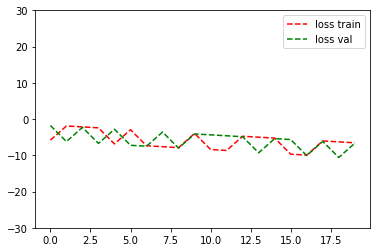

In [15]:
#plot training and validation loss
x_axis = np.arange(n_epochs)
plt.plot(x_axis, loss_vector, 'r--', label='loss train')
plt.plot(x_axis, loss_val_vector, 'g--', label='loss val')
plt.ylim(-30, 30)
plt.legend()

In [16]:
#check accuracy
def check_accuracy(loader, model):

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for imgs, labels in loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      outputs = model(imgs.view(imgs.shape[0], -1))
      _, predicted = torch.max(outputs, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())
        
  print("Accuracy: %f" % (correct / total))

In [17]:
#compute accuracy in training
check_accuracy(train_loader, seq_model)

Accuracy: 1.000000


In [18]:
#compute accuracy in test
check_accuracy(test_loader, seq_model)

Accuracy: 1.000000


In [19]:
#free some RAM
del seq_model
del dataset, dataset_t, transformed_dataset
del train_set, test_set, imgs

In [20]:
#increase the number of layers and change the loss to CrossEntropy
import torch.nn as nn
import torch.optim as optim
seq_model_large = nn.Sequential(
            nn.Linear(n_in, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, n_out))
seq_model_large = seq_model_large.to(device=device)
optimizer = optim.SGD(seq_model_large.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [21]:
#training and showing also validation loss
import time
t0 = time.time()
loss_vector, loss_val_vector = training_loop_val(
    model = seq_model_large,
    train_loader = train_loader,
    test_loader = test_loader,
    criterion = loss_fn,
    optimizer = optimizer,
    n_epochs = n_epochs)
print("Training time = %f seconds" %(time.time()-t0))

Epoch: 0, Training Loss: 0.051824, Validation Loss: 0.051285
Epoch: 1, Training Loss: 0.048760, Validation Loss: 0.047212
Epoch: 2, Training Loss: 0.046390, Validation Loss: 0.046132
Epoch: 3, Training Loss: 0.045436, Validation Loss: 0.043620
Epoch: 4, Training Loss: 0.043512, Validation Loss: 0.042926
Epoch: 5, Training Loss: 0.042930, Validation Loss: 0.042399
Epoch: 6, Training Loss: 0.041991, Validation Loss: 0.041832
Epoch: 7, Training Loss: 0.042678, Validation Loss: 0.041770
Epoch: 8, Training Loss: 0.041058, Validation Loss: 0.041836
Epoch: 9, Training Loss: 0.040505, Validation Loss: 0.040905
Epoch: 10, Training Loss: 0.040066, Validation Loss: 0.039628
Epoch: 11, Training Loss: 0.039645, Validation Loss: 0.039876
Epoch: 12, Training Loss: 0.038756, Validation Loss: 0.038629
Epoch: 13, Training Loss: 0.038317, Validation Loss: 0.039026
Epoch: 14, Training Loss: 0.037894, Validation Loss: 0.037780
Epoch: 15, Training Loss: 0.037482, Validation Loss: 0.037372
Epoch: 16, Trainin

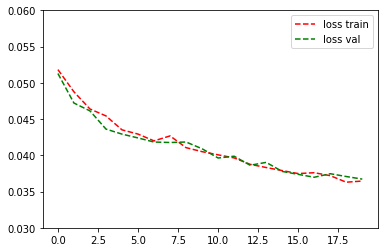

In [22]:
#plot training and validation loss
x_axis = np.arange(n_epochs)
plt.plot(x_axis, loss_vector, 'r--', label='loss train')
plt.plot(x_axis, loss_val_vector, 'g--', label='loss val')
plt.ylim(0.03, 0.06)
plt.legend()

In [23]:
#compute accuracy in training
check_accuracy(train_loader, seq_model_large)

Accuracy: 1.000000


In [24]:
#compute accuracy in test
check_accuracy(test_loader, seq_model_large)

Accuracy: 1.000000


A larger network with more layers does not fit in the RAM (here 14GB)! \\
Although the dataset of 6 images seems small, the number of parameters is actually large!

In [25]:
numel_list = [p.numel()
              for p in seq_model_large.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list              

(468277314, [468268800, 128, 8192, 64, 128, 2])

We have 3658350 (~4M) features per subject, which in the last fully connected network resulted in \\
3658350 * 128 + 812 + 64 + 128 + 2 = 468M parameters!
Possible solutions to decrese the number of parameters:
*   crop the images by removing most of the background
*   sample some 2D slices
*   downsample the images
*   use CNNs